# Research API

This notebook shows basic usage of the Research API (`/v0`) endpoints that calculate model outputs on specific flight trajectories and meteorology grids.
These endpoints provide hosted versions of [pycontrails](https://py.contrails.org) models run with re-analysis and forecast meteorology provided by ECMWF.

*These endpoints are subject to unannounced updates and potentially backward incompatible changes.*

In [1]:
import os
from pprint import pprint

In [2]:
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]
HEADERS = {"x-api-key": API_KEY}

## Trajectory APIs

Endpoints in the `/trajectory/` API each require POST requests. The POST body defines an individual flight: A sequence of discrete temporal spatial waypoints describing the 1D flight trajectory. See the [Fleet Computation](https://apidocs.contrails.org/notebooks/fleet_mode.html) guide for posting multiple distinct flights in one request.

The request body defines the parameterization of the flight into discrete waypoints. Responses use the same parameterization defined by the request body. For example, if a flight with 85 waypoints is passed into the `/trajectory/issr` endpoint, the response object will contain 85 ISSR predictions. These are in one-to-one corresponding with the request body.

We create a synthetic flight to use in this notebook as an example.

Not every field defined in the `flight` dictionary below is required for each endpoint. Apart from the four necessary temporal spatial fields (`longitude`, `latitude`, `altitude`, `time`), additional aircraft performance variables (`engine_efficiency`, `aircraft_mass`, ...) can be array-like (of the same length as the temporal spatial fields) or scalar-like if a constant value is to be used for all waypoints.

In [3]:
import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np  # pip install numpy
import pandas as pd  # pip install pandas

In [4]:
n_waypoints = 100
t0 = "2022-06-07T00:15:00"
t1 = "2022-06-07T02:30:00"

flight = {
    "longitude": np.linspace(-29, -50, n_waypoints).tolist(),
    "latitude": np.linspace(45, 42, n_waypoints).tolist(),
    "altitude": np.linspace(33000, 38000, n_waypoints).tolist(),
    "time": pd.date_range(t0, t1, periods=n_waypoints).astype(str).tolist(),
    "engine_efficiency": np.random.default_rng(42).uniform(0.2, 0.4, n_waypoints).tolist(),
    "aircraft_mass": np.linspace(65000, 62000, n_waypoints).tolist(),
    "aircraft_type": "A320",
}

### SAC

**POST [/v0/trajectory/sac](https://api.contrails.org/openapi#/Trajectory/schmidt_appleman_contrail_formation_criteria_v0_trajectory_sac_post)**

This endpoint calculates Schmidt-Appleman contrail formation criteria (SAC) along a flight trajectory.

The SAC is a binary model that indicates whether the flight forms an initial contrail. In particular, we use the following conventions.

- A value of 1 indicates the waypoint satisfies the SAC.
- A value of 0 indicates the waypoint does not satisfy the SAC.
- A null value indicates that the SAC state is not known for the waypoint. This most often occurs at terminal waypoints when engine efficiency is not known, or when the waypoint is not contained within the domain of the meteorology data.

[Engine efficiency](https://elib.dlr.de/9247/1/aerscitech-2000.pdf) is a critical parameter for the SAC. If the `engine_efficiency` field is not provided, it calculated via an aircraft performance model from the flight trajectory and the `aircraft_type` field.

In [5]:
import requests

r = requests.post(f"{URL}/v0/trajectory/sac", json=flight, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1739216736437194
met_source_provider: ECMWF
met_source_dataset: ERA5
met_source_product: reanalysis
pycontrails_version: 0.54.5
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
sac: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [6]:
flight_df = pd.DataFrame(flight).assign(sac=r_json["sac"])
flight_df.plot.scatter(x="longitude", y="latitude", c="sac", cmap="bwr", s=3);

### ISSR

**POST [/v0/trajectory/issr](https://api.contrails.org/openapi#/Trajectory/ice_super_saturated_regions_v0_trajectory_issr_post)**

This endpoint calculates ice super-saturated regions (ISSR) along a flight trajectory. Waypoints for which the ambient atmosphere has relative humidity over ice greater than 100% are considered to be in an ISSR.

We use the same value conventions as with the [SAC model](#SAC).

In [7]:
r = requests.post(f"{URL}/v0/trajectory/issr", json=flight, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1739216739195047
met_source_provider: ECMWF
met_source_dataset: ERA5
met_source_product: reanalysis
pycontrails_version: 0.54.5
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
issr: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


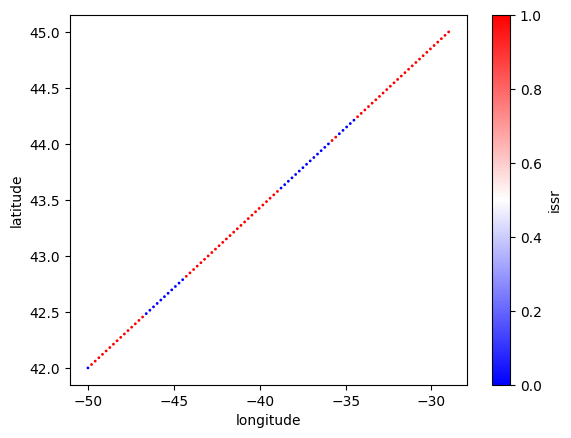

In [8]:
flight_df["issr"] = r_json["issr"]
flight_df.plot.scatter(x="longitude", y="latitude", c="issr", cmap="bwr", s=1);

### CoCiP

**POST [/v0/trajectory/cocip](https://api.contrails.org/openapi#/Trajectory/contrail_cirrus_predictions_v0_trajectory_cocip_post)**

The `/trajectory/cocip` endpoint implements the **Co**ntrail **Ci**rrus **P**rediction (CoCiP) model published in [Schumann 2012](https://gmd.copernicus.org/articles/5/543/2012/) and [Schumann et al 2012](https://journals.ametsoc.org/view/journals/apme/51/7/jamc-d-11-0242.1.xml). The API implementation includes updates from [Schumann 2015](https://acp.copernicus.org/articles/15/11179/2015/), [Teoh 2020](https://pubs.acs.org/doi/10.1021/acs.est.9b05608), and [Teoh 2022](https://acp.copernicus.org/preprints/acp-2022-169/).

The CoCiP model requires more meteorology data and compute time than the other models. Consequently, requesting predictions from the `/trajectory/cocip` endpoint takes some time.

In [9]:
r = requests.post(f"{URL}/v0/trajectory/cocip", json=flight, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")
r_json = r.json()

# The /trajectory/cocip endpoint includes many fields in the response.
for k, v in r_json.items():
    v = str(v)
    if len(v) > 80:
        v = v[:77] + "..."
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

cocip_max_contrail_age: 12 hours
cocip_dt_integration: 10 minutes
flight_id: 1739216741416708
met_source_provider: ECMWF
met_source_dataset: ERA5
met_source_product: reanalysis
pycontrails_version: 0.54.5
nvpm_data_source: ICAO EDB
engine_uid: 01P08CM105
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
sac: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0...
nox_ei: [0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.00...
nvpm_ei_n: [646000000000000.0, 647000000000000.0, 648000000000000.0, 649000000000000.0, ...
energy_forcing: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
contrail_age: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
initially_persistent: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0...


In [10]:
# Energy forcing is the primary model output.
ef = np.array(r_json["energy_forcing"], dtype=float)
ef

array([0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.10e+11, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.18e+12, 7.70e+11,
       4.60e+11, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 1.00e+10, 3.00e+10, 9.00e+10,
       1.30e+11, 1.40e+11, 1.20e+11, 9.00e+10, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 1.00e+10, 2.00e+10, 3.00e+10, 5.00e

In [11]:
flight_df["ef"] = ef
flight_df.plot.scatter(x="longitude", y="latitude", c="ef", cmap="Reds", s=3);

### Emissions

**POST [/v0/trajectory/emissions](https://api.contrails.org/openapi#/Trajectory/emissions_v0_trajectory_emissions_post)**

The `/trajectory/emissions` endpoint implements the aircraft performance models described in [Teoh 2020](https://pubs.acs.org/doi/10.1021/acs.est.9b05608) and [Teoh 2022](https://acp.copernicus.org/preprints/acp-2022-169/).

Presently, the emissions endpoint provides per-waypoint predictions for NOx and nvPM emissions. These values are derived from the [ICAO Aircraft Engine Emissions Databank](https://www.easa.europa.eu/en/domains/environment/icao-aircraft-engine-emissions-databank). An `engine_uid` field can be supplied to specify the engine type to query the databank. If not provided, the API will assume the engine is the most common engine associated with the aircraft type. Below, we don't supply the `engine_uid`, and so it is included in the response.

In [12]:
r = requests.post(f"{URL}/v0/trajectory/emissions", json=flight, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    v = str(v)
    if len(v) > 80:
        v = v[:77] + "..."
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1739216759877574
met_source_provider: ECMWF
met_source_dataset: ERA5
met_source_product: reanalysis
pycontrails_version: 0.54.5
nvpm_data_source: ICAO EDB
engine_uid: 01P08CM105
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
nox_ei: [0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.00...
nvpm_ei_n: [646000000000000.0, 647000000000000.0, 648000000000000.0, 649000000000000.0, ...


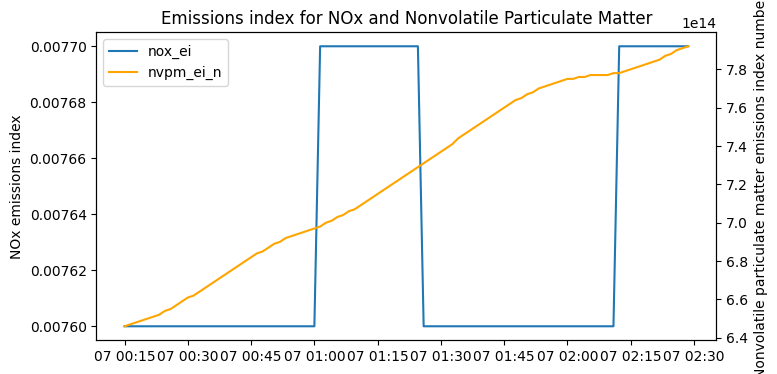

In [13]:
time = pd.to_datetime(flight["time"])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, r_json["nox_ei"], label="nox_ei")

ax2 = ax.twinx()
ax2.plot(time, r_json["nvpm_ei_n"], color="orange", label="nvpm_ei_n")

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc=0)

ax.set_ylabel("NOx emissions index")
ax2.set_ylabel("Nonvolatile particulate matter emissions index number")
ax.set_title("Emissions index for NOx and Nonvolatile Particulate Matter");

## Grid APIs

Grid endpoints evaluate a model of interest over a 4D temporal spatial grid. Presently, each grid endpoint requires a single timestamp, and so the grid's time coordinate contains a single value.

Unlike the trajectory endpoints, each grid endpoint is a GET request requiring query parameters. Commonly used query parameters include:

- `time`: the timestamp for the grid. Must be an ISO 8601 datetime string or unix timestamp (seconds since epoch).
- `flight_level`: one or multiple flight levels used to downselect the vertical coordinate of the grid. Must be a comma-separated string or list of integers. Available flight levels are 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440. If not provided, all flight levels are included in the response.
- `bbox`: a horizontal bounding box for the grid. Must be a comma-separated string or list of length 4. The order of the coordinates is `[min_lon, min_lat, max_lon, max_lat]`. The default is the bounding box of the entire domain (most of the entire globe).
- `format`: the format of the response data. This is a case-sensitive string (must be **lower-case**). Valid choices are:
  - `netcdf`: the response is a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) file. This is the default.
  - `geojson`: the response is [GeoJSON](https://geojson.org/) polygons. See below for examples of GeoJSON responses.
  - `kml`: the response is a [KML](https://developers.google.com/kml/documentation/kml_tut) representation of the GeoJSON polygons.

Examples of netCDF and GeoJSON responses are shown below.

### Data Availability

**GET [/v0/grid/availability](https://api.contrails.org/openapi#/Grid/grid_data_availability_v0_grid_availability_get)**

Grid endpoints in Contrails API serve data with varying availability. The `/v0/grid/availability` endpoint gives a range of times for which each `/grid` endpoint serves data.

In [14]:
r = requests.get(f"{URL}/v0/grid/availability", headers=HEADERS)

print(f"HTTP Response Code: {r.status_code} {r.reason}")
pprint(r.json())

HTTP Response Code: 200 OK
{'cocip': ['2022-01-01T00:00:00Z', '2025-02-11T12:00:00Z'],
 'issr': ['2018-01-01T00:00:00Z', '2025-02-13T06:00:00Z'],
 'pcr': ['2018-01-01T00:00:00Z', '2025-02-13T06:00:00Z'],
 'sac': ['2018-01-01T00:00:00Z', '2025-02-13T06:00:00Z']}


### SAC, ISSR, PCR

**GET [/v0/grid/sac](https://api.contrails.org/openapi#/Grid/schmidt_appleman_contrail_formation_criteria_v0_grid_sac_get)**

**GET [/v0/grid/issr](https://api.contrails.org/openapi#/Research/ice_super_saturated_regions_v0_grid_issr_get)**

**GET [/v0/grid/pcr](https://api.contrails.org/openapi#/Research/persistent_contrail_regions_v0_grid_pcr_get)**

The SAC, ISSR, and PCR grid endpoints all use similar conventions. 

We demonstrate the SAC grid endpoint here. 
This endpoint accepts an optional `engine_efficiency` parameter that takes a default value of 0.3.

In [15]:
import xarray as xr  # pip install xarray

In [16]:
time = "2022-06-07T02"
bbox = "-50,0,50,50"
params = {"time": time, "bbox": bbox, "engine_efficiency": 0.32}
r = requests.get(f"{URL}/v0/grid/sac", headers=HEADERS, params=params)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")

HTTP Response Code: 200 OK
Response content-type: application/netcdf


#### netCDF Response Format

The default response format is netCDF. For the SAC endpoint, the 4D grid holds a single `sac` variable. The response can be written out and read with `xarray`.

In [17]:
with open("sac.nc", "wb") as f:
    f.write(r.content)

da = xr.open_dataarray("sac.nc", engine="netcdf4")  # pip install netCDF4
da.coords  # each netCDF served in the API is a 4D grid

Coordinates:
  * time          (time) datetime64[ns] 8B 2022-06-07T02:00:00
  * flight_level  (flight_level) int32 72B 270 280 290 300 ... 410 420 430 440
  * longitude     (longitude) float32 2kB -50.0 -49.75 -49.5 ... 49.5 49.75 50.0
  * latitude      (latitude) float32 804B 0.0 0.25 0.5 0.75 ... 49.5 49.75 50.0

In [18]:
# The grid contains 18 flight levels ranging from 270 to 440.
da.flight_level.values

array([270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440], dtype=int32)

In [19]:
# We "squeeze" on time and select a single flight level to plot.
da.squeeze("time").isel(flight_level=10).plot(x="longitude", y="latitude", cmap="bwr");

#### GeoJSON Response Format

Contrails API supports two types of polygon formats: [GeoJSON](https://geojson.org/) and [KML](https://developers.google.com/kml/documentation/kml_tut).

We demonstrate the same grid endpoint using the GeoJSON representation here.

See the [polygon documentation](polygons.html) for additional examples including custom polygon simplification.

In [20]:
params["format"] = "geojson"
r = requests.get(f"{URL}/v0/grid/sac", headers=HEADERS, params=params)

print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")

r_json = r.json()

HTTP Response Code: 200 OK
Response content-type: application/json


In [21]:
import shapely.geometry as sgeom  # pip install shapely

GeoJSON type: FeatureCollection
{'description': 'Schmidt-Appleman contrail formation criteria',
 'engine_efficiency': 0.32,
 'humidity_scaling_formula': 'era5_quantiles -> iagos_quantiles',
 'humidity_scaling_name': 'histogram_matching',
 'level': 350,
 'level_long_name': 'Flight Level',
 'level_standard_name': 'FL',
 'level_units': 'hectofeet',
 'met_source_dataset': 'ERA5',
 'met_source_product': 'reanalysis',
 'met_source_provider': 'ECMWF',
 'name': 'sac',
 'polygon_iso_value': 0.5,
 'pycontrails_version': '0.52.1',
 'time': '2022-06-07T02:00:00Z'}


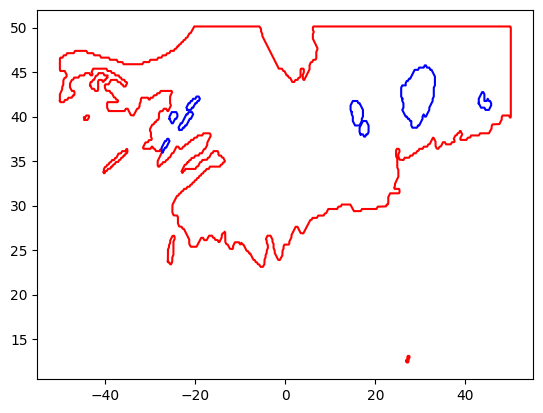

In [22]:
# The response body is a GeoJSON FeatureCollection. Each feature contains polygons for each flight level.
print(f"GeoJSON type: {r_json['type']}")

# Extract a feature
feature = r_json["features"][8]
pprint(feature["properties"])  # print out the metadata

# Visualize with shapely
# Polygons can have both exterior and interior rings
polygons = sgeom.shape(feature["geometry"])
for poly in polygons.geoms:
    plt.plot(*poly.exterior.xy, color="red")  # color exterior red
    for interior in poly.interiors:
        plt.plot(*interior.xy, color="blue")  # and interior blue

**Cleanup**

In [20]:
os.remove("sac.nc")